In [53]:
import mdtraj as md
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import pairwise_distances_argmin

from math import sqrt
import sys
import os

from datetime import date
from subprocess import call

In [54]:
project_dir = os.path.dirname(os.getcwd())

In [55]:
project_dir

'C:\\Users'

In [56]:
 %%time
top = os.path.join(project_dir + "\\data", "REFprotNEW.pdb")
nstxout = 10
stride = 1
skip = stride * nstxout
dt = 0.002

Wall time: 0 ns


In [57]:
trajname = os.path.join(project_dir + "\\data", "Crystals.dcd") 
iter_traj=md.iterload(filename=trajname,top=top,chunk=1)
traj = md.load(trajname[:],  stride = stride, top = top)

In [58]:
chunks=[]
index=0
for chunk in iter_traj:
    chunks=chunk

In [59]:
traj_res = [str(r) for r in traj.top.residues]
print("Total of residues in the structure:", len(traj_res))
print("First residue of chain A:", traj_res[0])
#print(str(traj_res))
print(chunks)

Total of residues in the structure: 2669
First residue of chain A: ACE2
<mdtraj.Trajectory with 1 frames, 42844 atoms, 2669 residues, and unitcells>


In [60]:
cleft1_cA = []
cleft1_cB = []
for i in range (len(traj_res)):
    cleft1_cA.append(traj_res[i])    
#cleft=["ACE2", "ASP3", "ALA4", "GLN5", "SER6"]
#for i in range (50):
    #cleft1_cA.append(traj_res[i])
#for i in range (51,53):
    #cleft1_cB.append(traj_res[i])    
#cleft1_cB = ["C37","U36"]
#print(cleft_cA)

In [61]:
cleft_BS1 = [traj_res.index(r,) for r in cleft1_cA]
print("Number of residues in BS1:", len(cleft_BS1))
print("Name of first residue in BS1:", traj_res[0])
print("Index of first residue in BS1:", cleft_BS1[0])
print("Index of last residue in BS1:", cleft_BS1[-1])
print("Number of residues in the cA part of BS1:", len(cleft1_cA))
print("Number of residues in the cB part of BS1:", len(cleft1_cB))
print("Index of residues in BS1:", cleft_BS1)

Number of residues in BS1: 2669
Name of first residue in BS1: ACE2
Index of first residue in BS1: 0
Index of last residue in BS1: 2612
Number of residues in the cA part of BS1: 2669
Number of residues in the cB part of BS1: 0
Index of residues in BS1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 17

In [124]:
pairs2=[]
pairs = list(itertools.combinations(cleft_BS1, 2))
print(len(pairs))
for i in range(0,len(pairs)-3500000):
    pairs2.append(pairs[i])
print(len(pairs2))    

3560446
60446


In [92]:
desc = [(str(traj_res[int(p[0])]), str(traj_res[int(p[1])])) for p in pairs]

In [93]:
output_dir = os.path.join(project_dir + "\\data", "output_compressed.npz")

In [94]:
distances, indices = md.compute_contacts(traj, contacts = pairs2, scheme = 'closest-heavy')

In [95]:
distances.shape

(1000, 60446)

In [96]:
npz_file = np.load(output_dir, allow_pickle = True)

In [97]:
distance_Y = list(npz_file["Y"])
feat_des = npz_file["desc"]

In [98]:
random_state = 100

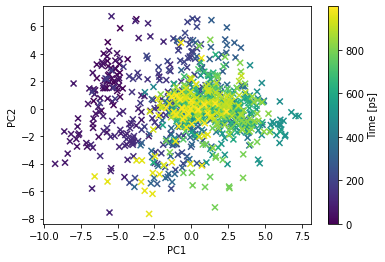

In [99]:
from sklearn.decomposition import PCA

pca_sklearn = PCA(random_state = random_state)
pca_components = pca_sklearn.fit_transform(distance_Y) * -1

plt.figure()
plt.scatter(pca_components[:, 0], pca_components[:,1], marker = 'x', c = traj.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')

plt.show()

In [100]:
def _to_free_energy(z, minener_zero=False):

    pi = z / float(z.sum())
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = pi.nonzero()
    free_energy[nonzero] = -np.log(pi[nonzero])

    if minener_zero:
        free_energy[nonzero] -= np.min(free_energy[nonzero])
    return free_energy

In [101]:
 def get_histogram(
        xall, yall, nbins = 100,
        weights = None, avoid_zero_count = False):
  
    z, xedge, yedge = np.histogram2d(
        xall, yall, bins = nbins, weights = weights)
    
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])

    if avoid_zero_count:
        z = np.maximum(z, np.min(z[z.nonzero()]))
    return x, y, z.T

In [102]:
x, y, z = get_histogram(pca_components[:,0], pca_components[:,1])

In [103]:
kT = 1.0
f = _to_free_energy(z, minener_zero =  True) * kT

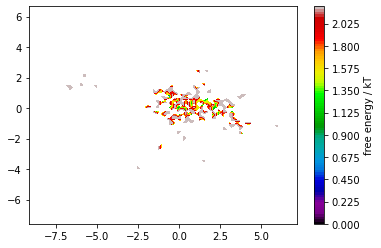

In [104]:
import matplotlib.pyplot as _plt

fig, ax = _plt.subplots()
mappable = ax.contourf(
    x, y, f, 100, norm = None,
    vmin = None, vmax = None, cmap = 'nipy_spectral',
    levels = None)

misc = dict(mappable = mappable)
cbar_ = fig.colorbar(
    mappable, ax = None, orientation = 'vertical')
cbar_.set_label('free energy / kT')

plt.show()

In [105]:
pca_eigenvalues = pca_sklearn.explained_variance_ratio_

In [106]:
 pc_id = list(range(len(pca_eigenvalues)))

In [107]:
 pca_eigen_df = pd.DataFrame({"pc_id": pc_id, "eig_cum": np.cumsum(pca_eigenvalues), "eig_values": pca_eigenvalues})

In [108]:
pca_eigen_df.head()

,pc_id,eig_cum,eig_values
0,0,0.323162,0.323162
1,1,0.494468,0.171306
2,2,0.586949,0.092481
3,3,0.652430,0.065481
4,4,0.690737,0.038307


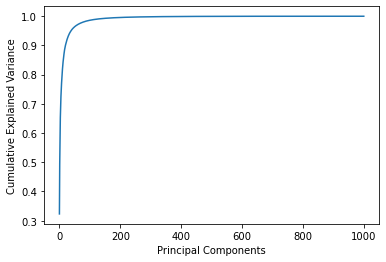

In [109]:
plt.plot(np.cumsum(pca_eigenvalues))
plt.xlabel("Principal Components")
plt.ylabel('Cumulative Explained Variance')
plt.show()

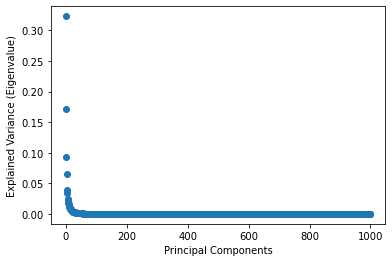

In [110]:
plt.scatter(np.arange(len(pca_eigenvalues)), pca_eigenvalues)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance (Eigenvalue)")
plt.show()

In [111]:
n_pca = pca_eigen_df[pca_eigen_df['eig_cum'] <= 0.7]
n_pca = n_pca.shape[0]

In [112]:
print(n_pca)

5


In [113]:
def optimal_number_of_clusters(wcss):
    # Function to define the optimal number of clusters
    x1, y1 = 1, wcss[0]
    x2, y2 = 100, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [114]:
 pca_components_df = pd.DataFrame(pca_components)

In [115]:
X = pca_components_df.iloc[:,:n_pca]
X.shape

(1000, 5)

In [116]:
inertias = []
K = range(1, 100)

for k in K:
    model = KMeans(n_clusters = k, random_state = random_state)
    model.fit(X)
    inertias.append(model.inertia_)

C:\Users\Mondello\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


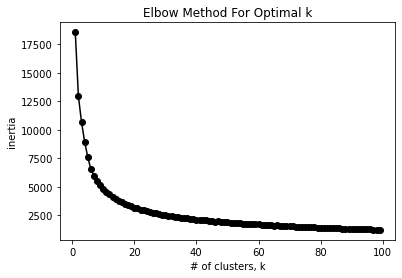

In [117]:
plt.plot(K, inertias, '-o', color='black')
plt.xlabel('# of clusters, k')
plt.ylabel('inertia')
plt.title('Elbow Method For Optimal k')

plt.show()

In [118]:
n = optimal_number_of_clusters(inertias)
print("Optimal number of clusters: ", n)

Optimal number of clusters:  14


In [119]:
km = KMeans(n_clusters = n)
km = km.fit(X)

In [120]:
OPTIONAL = True
execution = date.today().strftime('%Y-%m-%d')

closest = pairwise_distances_argmin(km.cluster_centers_, X)
representatives = []

try:
    os.makedirs(os.path.join(project_dir + "/data/" + "clusters", execution))
except OSError:
    print ("Creation of the directory %s failed" % execution)
else:
    print ("Successfully created the directory %s " % execution)

for i in enumerate(closest):
    traj_index = int((i[1]-1) / traj.n_frames)
    frame_index = i[1]-(traj_index * traj.n_frames)

    n_cluster = str(i[0])
    
    representatives.append([traj_index, frame_index, i[1]])
    print(f"Closest conformation inside cluster {n_cluster} can be found in trajectory {traj_index} frame {frame_index}, (index {i[1]})")

    if OPTIONAL:   
        convert_command = f"mdconvert {trajname} -t {top} -o {project_dir}/data/clusters/{execution}/PCA_in_cluster_{n_cluster}_{frame_index}.pdb -i {frame_index}"        
        print(convert_command)

        call(convert_command, shell = True)

Successfully created the directory 2021-06-25 
Closest conformation inside cluster 0 can be found in trajectory 0 frame 386, (index 386)
mdconvert C:\Users\data\Crystals.dcd -t C:\Users\data\REFprotNEW.pdb -o C:\Users/data/clusters/2021-06-25/PCA_in_cluster_0_386.pdb -i 386
Closest conformation inside cluster 1 can be found in trajectory 0 frame 65, (index 65)
mdconvert C:\Users\data\Crystals.dcd -t C:\Users\data\REFprotNEW.pdb -o C:\Users/data/clusters/2021-06-25/PCA_in_cluster_1_65.pdb -i 65
Closest conformation inside cluster 2 can be found in trajectory 0 frame 891, (index 891)
mdconvert C:\Users\data\Crystals.dcd -t C:\Users\data\REFprotNEW.pdb -o C:\Users/data/clusters/2021-06-25/PCA_in_cluster_2_891.pdb -i 891
Closest conformation inside cluster 3 can be found in trajectory 0 frame 453, (index 453)
mdconvert C:\Users\data\Crystals.dcd -t C:\Users\data\REFprotNEW.pdb -o C:\Users/data/clusters/2021-06-25/PCA_in_cluster_3_453.pdb -i 453
Closest conformation inside cluster 4 can be 

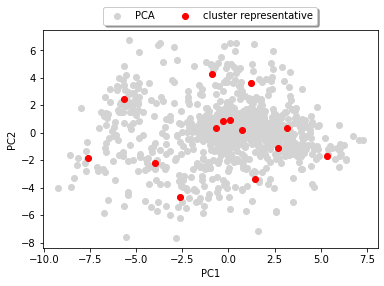

In [121]:
plt.scatter(pca_components[:,0], pca_components[:,1], c="lightgrey")
plt.xlabel("PC1")
plt.ylabel("PC2")

[plt.scatter(pca_components[yr[2],0], pca_components[yr[2],1], c="red") for yr in representatives]

plt.legend(["PCA", "cluster representative"], loc='upper center', bbox_to_anchor=(0.5, 1.13), fancybox=True, shadow=True, ncol=5)

plt.show()

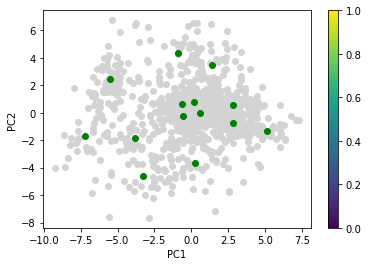

In [122]:
cc = km.cluster_centers_

#plotting all elements
plt.scatter(pca_components_df.iloc[:, 0], pca_components_df.iloc[:, 1], c = "lightgrey")
plt.xlabel("PC1")
plt.ylabel("PC2")

# plotting cluster centers
plt.scatter(cc[:, 0], cc[:, 1], c="green") 
plt.colorbar()
plt.show()